# Plot H5Nx North America Nextstrain DTA

August 15, 2019

This notebook contains code for producing the full North American tree, generated by running all North American genomes though Beast 1.8 with a skygrid population size prior, and inferring migration history with DTA for all 22 US states/Canadian provinces. This will produce the tree in Figure 1a. 

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import json
import imp
bt = imp.load_source('baltic', '../baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
#from scipy.special import binom

/var/folders/pq/2r34219j1gqfwwbv1ks0440w0000gr/T/ipykernel_50257/1670090864.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('text', usetex='false') 
mpl.rcParams.update({'font.size': 22})

In [3]:
from datetime import date

today_date = str(date.today())
print(today_date)

2024-02-06


In [4]:
# to run on 1 json
tree_json='nextstrain-jsons-from-Annas-build/h5nx-ha-north-america-2024-02-06.json'
json_translation={'absoluteTime':'num_date','height':'branch_length','name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum

In [5]:
with open(tree_json) as json_file:
    h5_tree_json = json.load(json_file)
    tree_object=h5_tree_json['tree']
    meta=h5_tree_json['meta']

json_translation={'absoluteTime':lambda k: k.traits['node_attrs']['num_date']['value'],'name':'name'} ## allows baltic to find correct attributes in JSON, height and name are required at a minimum
# #json_meta={'file':meta,'traitName':analysis_level} ## if you want auspice stylings you can import the meta file used on nextstrain.org

tree=bt.loadJSON(tree_object,json_translation)


Tree height: 2.578950
Tree length: 286.799206
annotations present

Numbers of objects in tree: 3494 (1513 nodes and 1981 leaves)



In [6]:
all_hosts = []

for k in tree.Objects: 
    if k.branchType == "leaf":
        if "Domestic_Status" in k.traits["node_attrs"]:
            domestic_status = k.traits["node_attrs"]["Domestic_Status"]["value"]
            all_hosts.append(domestic_status)
            
    elif k.branchType == "node":
        pass
        #print(k.traits)
print(set(all_hosts))

{'name': 'NODE_0000001', 'node_attrs': {'div': 0, 'num_date': {'value': 2021.079954011257, 'confidence': [2020.4502616868442, 2021.2658519507327]}, 'Domestic_Status': {'value': 'Wild', 'confidence': {'': 0.05520456162600203, 'Domestic': 0.08797071524972729, 'Unknown': 0.087456177525888, 'Wild': 0.732946422868205}, 'entropy': 0.9572270234800849}, 'flyway': {'value': 'Atlantic Flyway', 'confidence': {'Atlantic Flyway': 0.6043441236530238, 'Central Flyway': 0.10166470580190527, 'Mississippi Flyway': 0.10689361659985433, 'Pacific Flyway': 0.1867572012193823}, 'entropy': 1.091859878573906}, 'region': {'value': 'North America'}, 'division': {'value': 'North Carolina', 'confidence': {'Alaska': 0.06480495395430401, 'British Columbia': 0.10440817121989009, 'North Carolina': 0.5791201561905848, 'South Carolina': 0.013465312198983231}, 'entropy': 2.068140959771981}, 'country': {'value': 'Canada', 'confidence': {'Canada': 0.9154991983947743, 'Usa': 0.08447279526103038}, 'entropy': 0.28990956508890

In [14]:
def plot_tree(tree,traitName,filename,color_list):
    
    fig,ax = plt.subplots(figsize=(10,8),facecolor='w')

    # # this sets the vertical dashed lines on the tree; plot a dashed line every other year from 1990 to 2020
    dates_ls = []
    for i in range(2021,2025,1):
        dates_ls.append(i)  
    #dates = dates_ls[::2]
    #[ax.axvline(i,ls='--',lw=2,color='grey',zorder=0, alpha=0.6) for i in dates]

    # set date labels to be every 4
    # date_labels = []
    # for d in dates_ls[::4]:
    #     date_labels.append(str(d))
    #     if d < 2018:
    #         date_labels.append("")

    branchWidth=1.25 ## default branch width
    tipSize = 15

    # k objects are tips, nodes, branches
    for k in tree.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y 

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...

            if traitName in k.traits["node_attrs"]:
                trait_value = k.traits["node_attrs"][traitName]["value"]
                trait_prob = k.traits["node_attrs"][traitName]["confidence"][trait_value]
            else:
                trait_value = "U"
                trait_prob = 0
            base_color=colors[trait_value]
            color_ramp = clr.LinearSegmentedColormap.from_list('custom ', ["#B9B9B9",base_color], N=256)
            c = color_ramp(trait_prob)
            s=tipSize

            ax.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            number_children = len(k.leaves)
            node_branchwidth = branchWidth + number_children*0.0025


            if traitName in k.traits["node_attrs"]:
                trait_value = k.traits["node_attrs"][traitName]["value"]
                trait_prob = k.traits["node_attrs"][traitName]["confidence"][trait_value]
            else:
                trait_value = "U"
                trait_prob = 0

            base_color=colors[trait_value]
            color_ramp = clr.LinearSegmentedColormap.from_list('custom ', ["#B9B9B9",base_color], N=256)
            c = color_ramp(trait_prob)
            ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=node_branchwidth,color=c,ls='-',zorder=9) #color=node_colors[node_types[k]["node_community_status"]]

        ax.plot([xp,x],[y,y],lw=node_branchwidth,color=c,ls='-',zorder=9)

        # add in a legend
        han_list = []

        # bbox to anchor puts a bounding box around where you want the legend to go, prop part is for text size
    for key in color_list:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title().replace("Nonhuman Mammal","Nonhuman\nMammal").replace("U","Unknown"), markersize = 10, markeredgewidth=2)
        han_list.append(marker)

    # set axis limits, remove border lines         
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    ax.set_ylim(-10,tree.ySpan+10)
    ax.set_xlim(2020.5,2024)
    ax.tick_params(axis='y',labelsize=0,size=0)
    ax.tick_params(axis='x',labelsize=24,size=5, width=2,color='grey')
    ax.set_xticks(dates_ls)
    ax.set_xticklabels(dates_ls)   # set date labels every 4
    ax.set_yticklabels([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax.legend(handles = han_list, markerfirst = True, edgecolor="white", framealpha=1, bbox_to_anchor=[-0.02, 0.02], loc=3,prop={'size': 22}, facecolor='w')

    fig.tight_layout()
    plt.gcf().subplots_adjust(right=0.88)
    plt.savefig(filename)

    plt.show()

In [18]:
# try instead, clustering into regions and plotting it that way; we could do: west, 2 midwests, 2 souths, northeast
colors = {"Backyard Bird":"#D1BA56",
          "Wild":"#2664A5",
          "Nonhuman Mammal":"#B2313D",
          "Domestic":"#5CA7A4",
          "U":"#B9B9B9", 
          
         "Atlantic Flyway": "#4274CE",
         "Mississippi Flyway": "#69B091",
         "Pacific Flyway":"#E39B39", 
         "Central Flyway": "#ADBD51", 
         
                   
         "Atlantic Flyway": "#4274CE",
         "Mississippi Flyway": "#69B091",
         "Pacific Flyway":"#E56C2F", 
         "Central Flyway": "#CEB541"}

# colors = {"Backyard Bird":"#5CA7A4",
#           "Wild":"#2664A5",
#           "Nonhuman Mammal":"#B2313D",
#           "Domestic":"#5CA7A4",
#           "U":"#B9B9B9"}


uncertainty_color:"#B9B9B9"

color_order = ["Wild","Domestic","Backyard Bird","Nonhuman Mammal","U"]

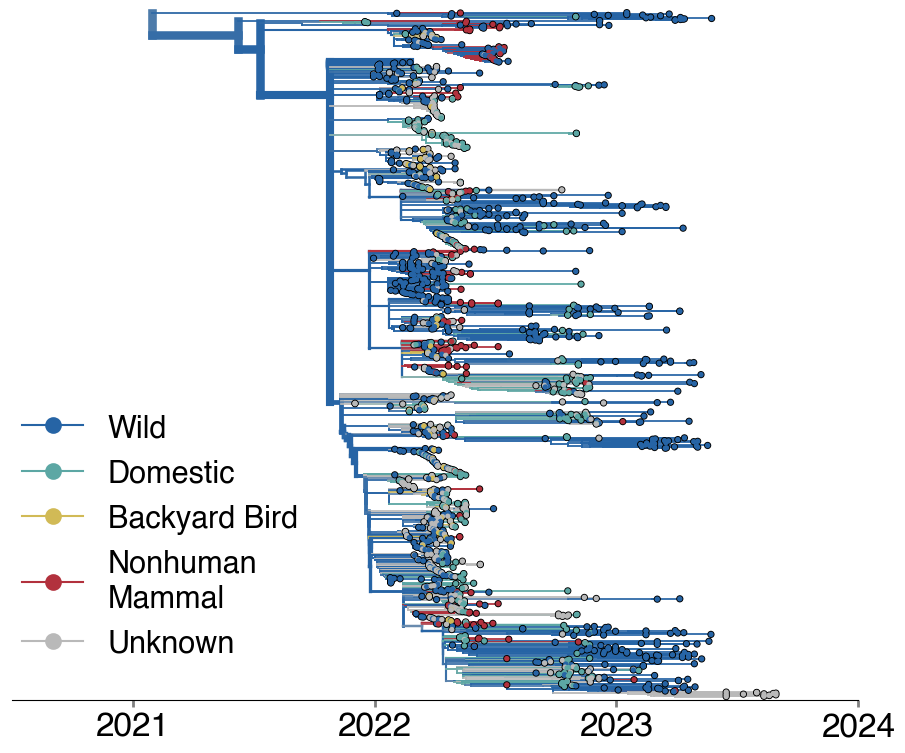

In [9]:
# set output filename

traitName = "Domestic_Status"
filename = "figures/Nextstrain-tree-North-America-colorby-"+traitName+"-"+today_date+".pdf"
plot_tree(tree,traitName,filename)

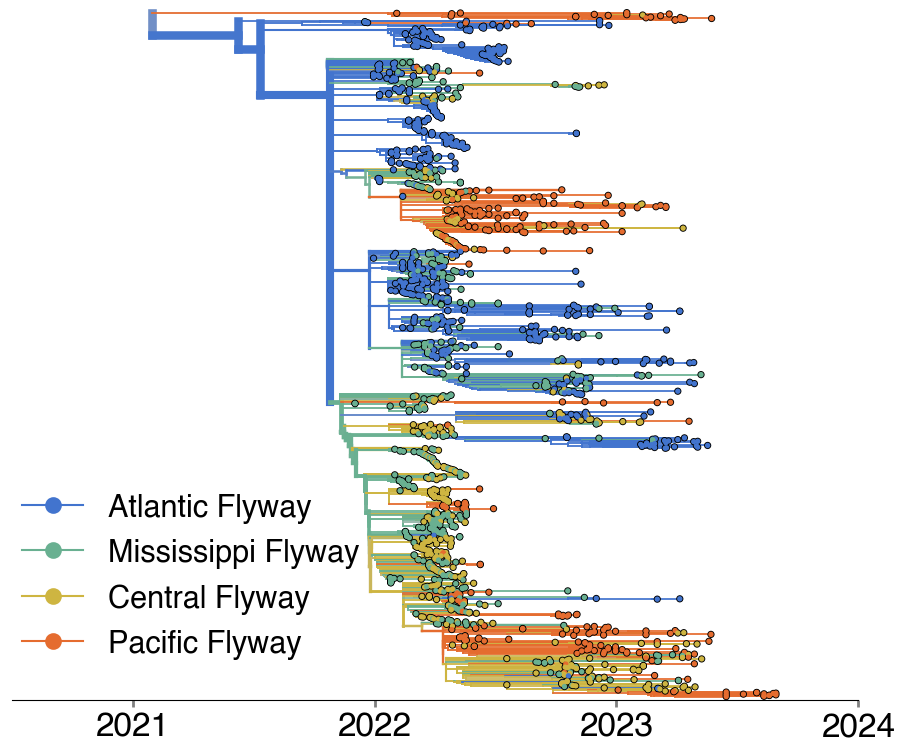

In [19]:
# set output filename

traitName = "flyway"
color_list = ["Atlantic Flyway","Mississippi Flyway", "Central Flyway","Pacific Flyway"]
filename = "figures/Nextstrain-tree-North-America-colorby-"+traitName+"-"+today_date+".pdf"
plot_tree(tree,traitName,filename,color_list)